In [1]:
import tensorflow as tf

# Para el acceso a los ficheros
import os
# Para las imágenes
import numpy as np
import cv2 # OpenCV-Python
import matplotlib.pyplot as plt
import tempfile
from PIL import Image
from scipy import ndimage

In [40]:
images_path = "../../Report/Images/"

In [19]:
def download_and_load_model(model_file="image_segmentation_model.pb", tflite_model_type="fp16"):
    # Load the TensorFlow model
    # The preprocessing and the post-processing steps should not be included in the TF Lite model graph
    # because some operations (ArgMax) might not support the delegates.
    # Insepct the graph using Netron https://lutzroeder.github.io/netron/
    converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
        graph_def_file = model_file,
        input_arrays = ['sub_7'],
        output_arrays = ['ResizeBilinear_2']
    )

    # Optional: Perform the simplest optimization known as post-training dynamic range quantization.
    # https://www.tensorflow.org/lite/performance/post_training_quantization#dynamic_range_quantization
    # You can refer to the same document for other types of optimizations.
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Convert to TFLite Model
    tflite_model = converter.convert()

    _, dynamic_tflite_path = tempfile.mkstemp('.tflite')
    tflite_model_size = open(dynamic_tflite_path, 'wb').write(tflite_model)
    tf_model_size = os.path.getsize(model_file)
    converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
        graph_def_file = model_file,
        input_arrays = ['sub_7'],
        output_arrays = ['ResizeBilinear_2']
    )
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]

    tflite_model = converter.convert()

    _, f16_tflite_path = tempfile.mkstemp('.tflite')
    tflite_model_size = open(f16_tflite_path, 'wb').write(tflite_model)
    tf_model_size = os.path.getsize(model_file)

    model_dict = {
        "dynamic-range": dynamic_tflite_path,
        "fp16": f16_tflite_path,
    }

    tflite_model_type = tflite_model_type # @param ['dynamic-range', 'fp16', 'int8']

    # Load the model.
    interpreter = tf.lite.Interpreter(model_path=model_dict[tflite_model_type])

    # Set model input.
    input_details = interpreter.get_input_details()

    # Get image size - converting from BHWC to WH
    input_size = input_details[0]['shape'][2], input_details[0]['shape'][1]

    return interpreter, input_size, input_details

In [20]:
interpreter, input_size, input_details = download_and_load_model()

## DeepLab COCO
Based on code from Google Colab Notebook: https://tfhub.dev/sayakpaul/lite-model/mobilenetv2-dm05-coco/dr/1

In [21]:
def get_person_and_moto_mask(image_array, input_size, interpreter):
    # Create Image variable from the array
    image = Image.fromarray(image_array)

    # Resize the image to the desired model size
    resized_image = image.convert('RGB').resize(input_size, Image.BILINEAR)

    # Convert to a NumPy array, add a batch dimension, and normalize the image.
    image_for_prediction = np.asarray(resized_image).astype(np.float32)
    image_for_prediction = np.expand_dims(image_for_prediction, 0)
    image_for_prediction = image_for_prediction / 127.5 - 1

    # Invoke the interpreter to run inference.
    interpreter.allocate_tensors()
    interpreter.set_tensor(input_details[0]['index'], image_for_prediction)
    interpreter.invoke()

    # Retrieve the raw output map.
    raw_prediction = interpreter.tensor(
        interpreter.get_output_details()[0]['index'])()
    width, height = image.size
    seg_map = tf.argmax(tf.image.resize(raw_prediction, (height, width)), axis=3)
    seg_map = tf.squeeze(seg_map).numpy().astype(np.int8)
    mask = np.logical_not(np.logical_or(seg_map == 14, seg_map==15))

    return mask, seg_map

In [22]:
def extract_box(img, mask):
    motos, number_of_motos = ndimage.label(np.logical_not(mask))
    unique, counts = np.unique(motos, return_counts=True)
    moto_label = np.argmax(counts[1:]) + 1
    mask_moto = np.logical_not(motos==moto_label)
    shape1, shape0 = mask_moto.shape
    prod_axis0 = np.prod(mask_moto, axis=0)
    prod_axis1 = np.prod(mask_moto, axis=1)
    min_axis0 = np.argmin(prod_axis0)
    max_axis0 = shape0 - np.argmin(prod_axis0[::-1])
    min_axis1 = np.argmin(prod_axis1)
    max_axis1 = shape1 - np.argmin(prod_axis1[::-1])
    return img[min_axis1:max_axis1, min_axis0:max_axis0,:]

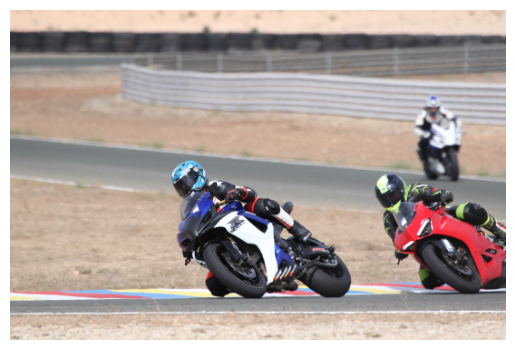

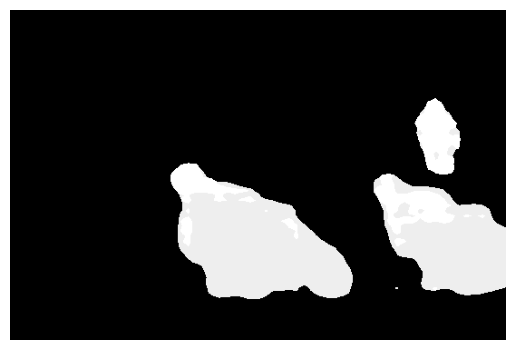

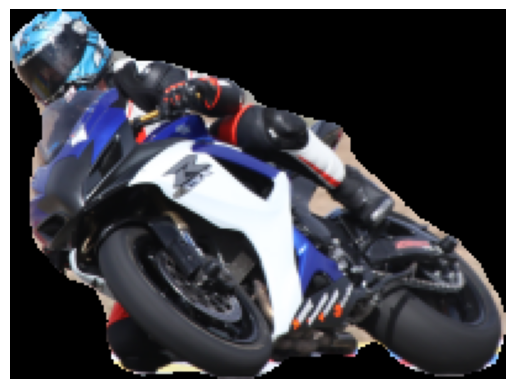

In [43]:
data_path = "../../Circuito_Almeria_171021/Iniciados/Data/"
img = cv2.imread(data_path + "10" + "/" + os.listdir(data_path + os.listdir(data_path)[1])[18])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Set the percentage of the resolution desired
scale_percent = 10
# THE NEW DIMENSIONS ARE COMPUTED
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)

# Resizing the image
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
img_copy = img.copy()
mask, seg_map = get_person_and_moto_mask(img, input_size, interpreter)
img[mask, :] = 0
img_boxed = extract_box(img, mask)

plt.imshow(img_copy)
plt.axis("off")
plt.savefig(os.path.join(images_path, "imagen_ejemplo_segmentacion.jpg"), dpi=300, bbox_inches="tight")
plt.show()
plt.imshow(seg_map, cmap="gray")
plt.axis("off")
plt.savefig(os.path.join(images_path, "mascara_segmentacion.jpg"), dpi=300, bbox_inches="tight")
plt.show()
plt.imshow(img_boxed)
plt.axis("off")
plt.savefig(os.path.join(images_path, "resultado_segmentacion.jpg"), dpi=300, bbox_inches="tight")
plt.show()

In [41]:
%timeit get_person_and_moto_mask(img, input_size, interpreter)

170 ms ± 22.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
